## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import wave
import sys
import scipy
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = [16,12]
plt.rcParams.update({'font.size': 18})

## Generating Sample Waves


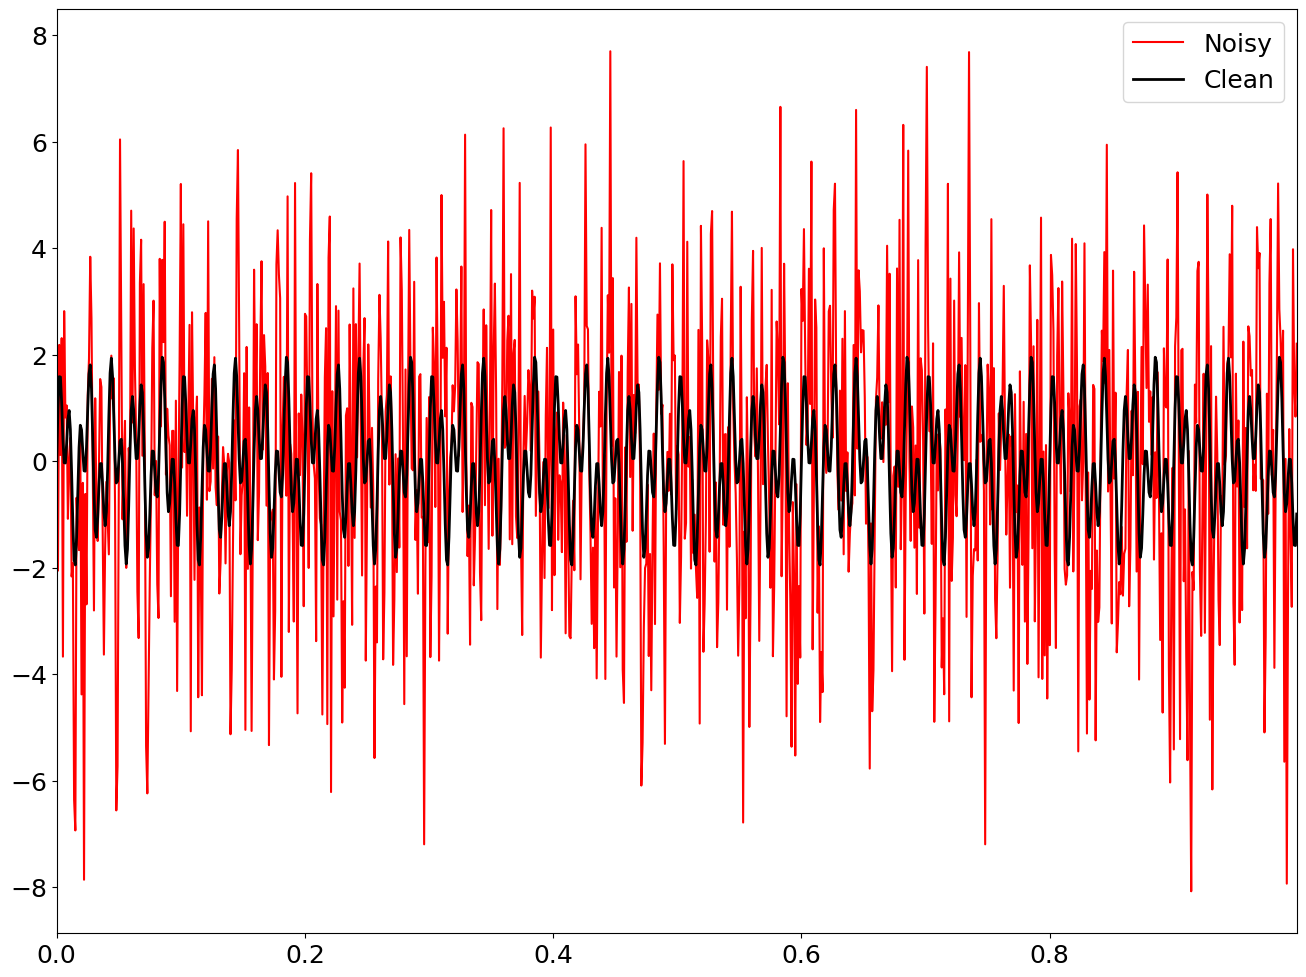

In [ ]:
### DEFINE SAMPLE CLEAN AND NOISY WAVE ###

dt = 0.001 # Define smallest time step; 'sample rate'
t = np.arange(0, 1, dt) # Define range from 0 to 1

f = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t) # Sample sinusoidal wave
f_clean = f # Clean
f = f + 2.5*np.random.randn(len(t)) # Add noise

plt.plot(t, f, color='red', linewidth=1.5, label='Noisy')
plt.plot(t, f_clean, color='k', linewidth=2, label='Clean')
plt.xlim(t[0], t[-1])
plt.legend()

In [ ]:
# RUN ONCE
# %cd ./content

In [ ]:
### LET'S HEAR THEM ###
# https://stackoverflow.com/questions/58178732/how-to-create-a-wav-file-from-data-points-of-a-sound-wave

sample_rate = 44100
amplitude = np.iinfo(np.int16).max # Max 16-bit value as amplitude
freq = 100

def generateWav(data, amplitude, sample_rate, name):
  data = amplitude * data

  write(f"{name}.wav", sample_rate, data.astype(np.int16))

def generateSin(freq, amplitude, sample_rate):
  t = np.linspace(0., 1., sample_rate)

  data = amplitude * np.sin(2. * np.pi * freq * t)

  write(f"sin{freq}.wav", sample_rate, data.astype(np.int16))

## Denoising the Noisy Sample via Fast Fourier Transform

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


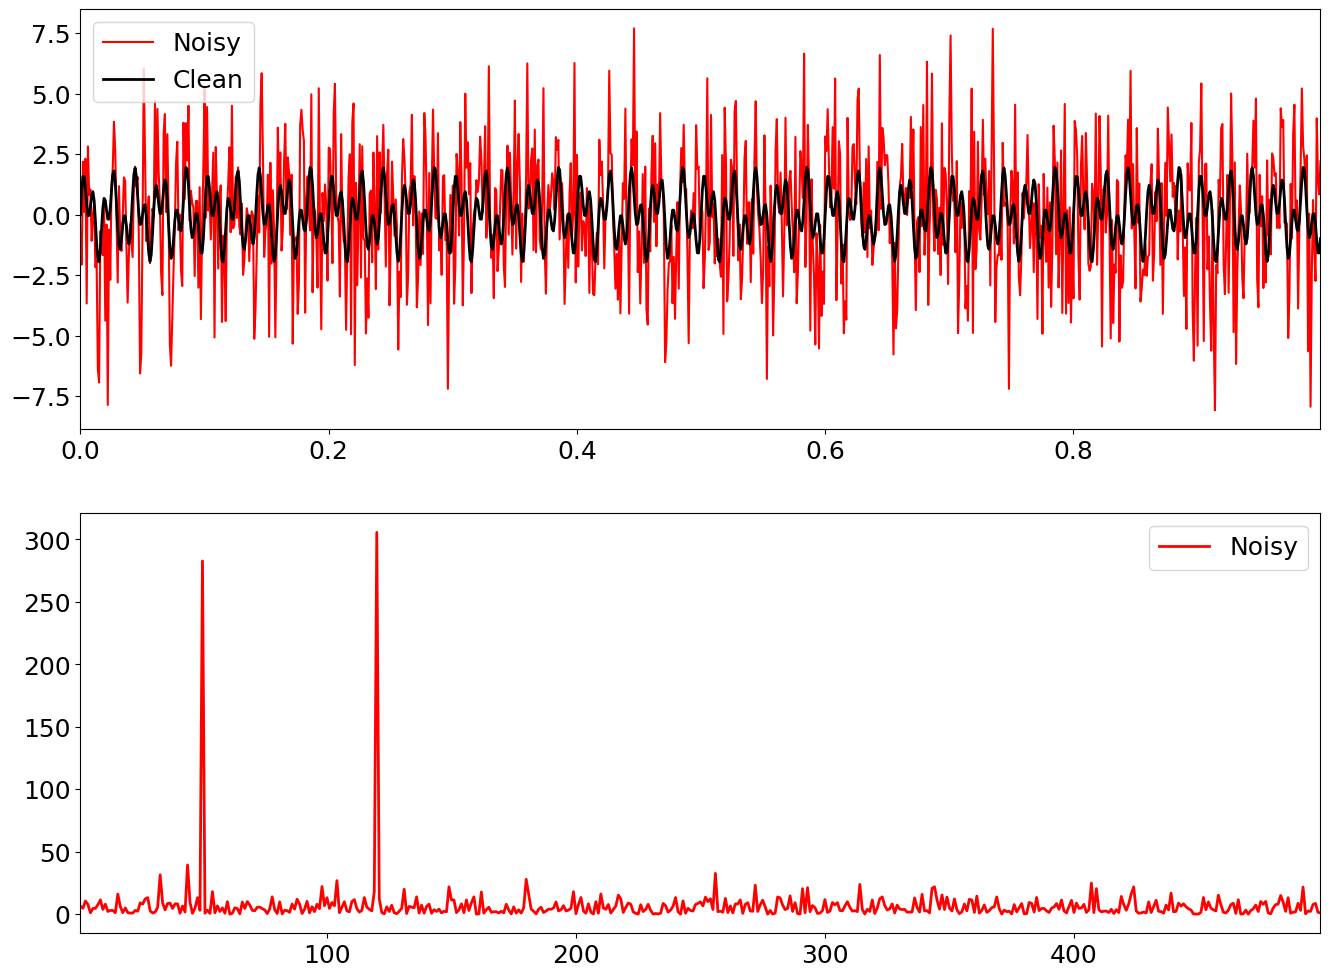

In [ ]:
### DEFINE AND VISUALIZE FFT ###

def fftPlotSample(t, dt, clean, noisy):
  n = len(t)
  fhat = np.fft.fft(f, n) # Compute FFT
  PSD = fhat * np.conj(fhat) / n   # lambda * conj(lambda) = |lambda|^2 = a^2 + b^2
                                   # lambda = a + bi, conj(lambda) = a - bi
                                   # Vector that maps some value of magnitude/power to each frequency
                                   # This will be the new y-axis
  freq = (1 / (dt*n)) * np.arange(n) # 1000 samples => 1000 frequency values
                                     # Our x-axis
  L = np.arange(1, np.floor(n / 2), dtype='int')

  fig, axs = plt.subplots(2, 1)

  plt.sca(axs[0])
  plt.plot(t, noisy, color='red', linewidth=1.5, label='Noisy')
  plt.plot(t, clean, color='k', linewidth=2, label='Clean')
  plt.xlim(t[0], t[-1])
  plt.legend()

  plt.sca(axs[1])
  plt.plot(freq[L], PSD[L], color='red', linewidth=2, label='Noisy')
  plt.xlim(freq[L[0]], freq[L[-1]])
  plt.legend()

  plt.show()

fftPlotSample(t, dt, f_clean, f)

<ipython-input-3-ff059c0ccc82>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  write(f"{name}.wav", sample_rate, data.astype(np.int16))


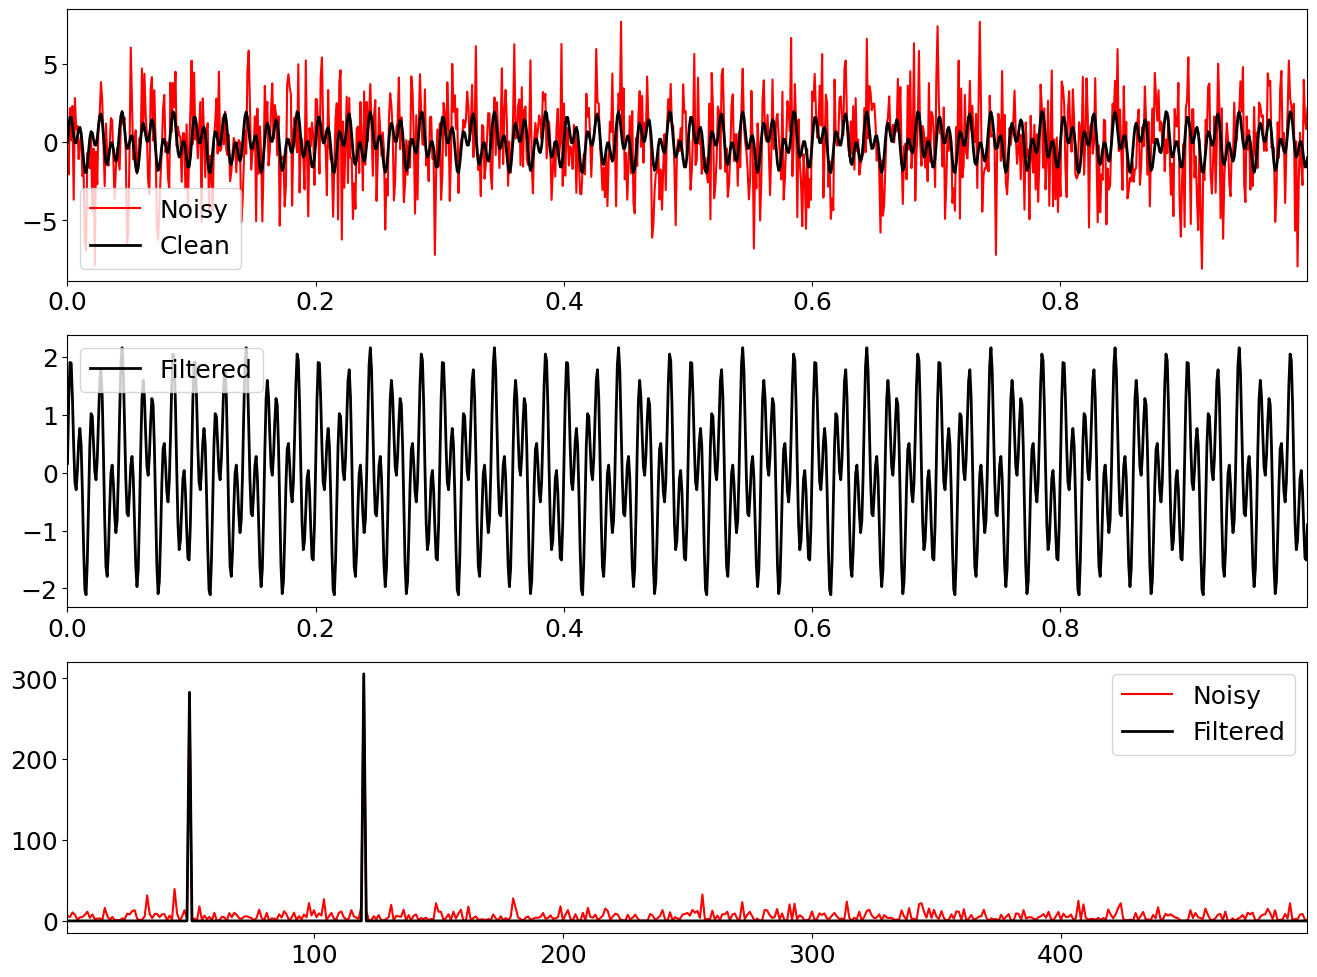

In [ ]:
### VISUALIZE DENOISE ON SAMPLE NOISY WAVE ###
# https://www.sciencedirect.com/topics/computer-science/power-spectral-density#:~:text=Power%20spectral%20density%20(PSD)%20describes,a%20time%20domain%20data%20stream.

def ifftPlotSample(t, dt, clean, noisy):
  # TRANSFORM
  n = len(t)
  fhat = np.fft.fft(f, n) # Compute FFT
  PSD = fhat * np.conj(fhat) / n   # lambda * conj(lambda) = |lambda|^2 = a^2 + b^2
                                   # lambda = a + bi, conj(lambda) = a - bi
                                   # Vector that maps some value of magnitude/power to each frequency
                                   # This will be the new y-axis
  freq = (1 / (dt*n)) * np.arange(n) # 1000 samples => 1000 frequency values
                                     # Our x-axis
  L = np.arange(1, np.floor(n / 2), dtype='int')

  # FILTER
  indices = PSD > 100 # Map True or False for each value in PSD; Basically the 'filter'; If PSD > 100, keep it
  PSDclean = PSD * indices # Apply the filter
  fhat = indices * fhat # Apply filter

  # INVERSE TRANSFORM
  ffilt = np.fft.ifft(fhat) # Apply inverse FFT on filtered signal

  # GENERATE FILTERED WAV
  amplitude = np.iinfo(np.int16).max
  generateWav(ffilt, amplitude, 44100, "ffilt") # Remove complex coefficients resulting from calculation error

  # PLOT
  fig, axs = plt.subplots(3, 1)

  plt.sca(axs[0])
  plt.plot(t, noisy, color='red', linewidth=1.5, label='Noisy')
  plt.plot(t, clean, color='k', linewidth=2, label='Clean')
  plt.xlim(t[0], t[-1])
  plt.legend()

  plt.sca(axs[1])
  plt.plot(t, ffilt, color='k', linewidth=2, label='Filtered')
  plt.xlim(t[0], t[-1])
  plt.legend()

  plt.sca(axs[2])
  plt.plot(freq[L], PSD[L], color='red', linewidth=1.5, label='Noisy')
  plt.plot(freq[L], PSDclean[L], color='k', linewidth=2, label='Filtered')
  plt.xlim(freq[L[0]], freq[L[-1]])
  plt.legend()

  plt.show()

ifftPlotSample(t, dt, f_clean, f)

## Testing on Sample .wav File

In [ ]:
# RUN ONCE
# !git clone https://github.com/rbsolas/Signal-Processing.git
%ls
%cd Signal-Processing/

output.wav  sample_clean.wav  sample_data/  sample_noisy.wav  Signal-Processing/
/content/Signal-Processing


In [ ]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


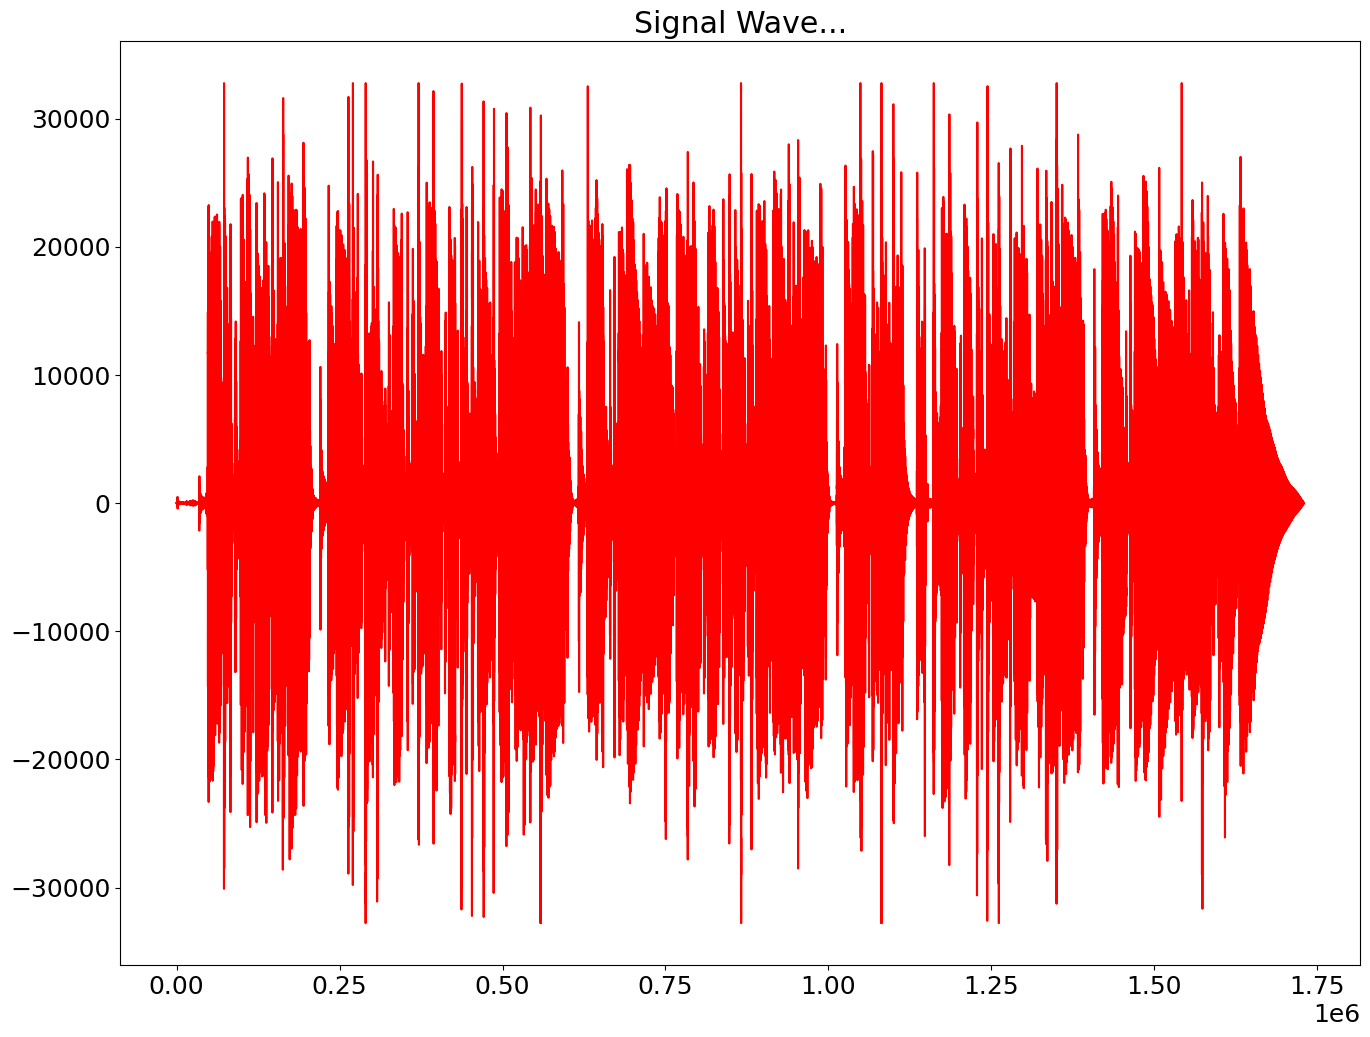

In [ ]:
### OPEN A SAMPLE WAV ###
PATH_TO_WAV = ""

spf = wave.open("wav/goat.wav", "r")

def extractAudio(spf):
  # If Stereo
  if spf.getnchannels() == 2:
      print("Just mono files")
      sys.exit(0)

  # Extract Raw Audio from Wav File
  signal = spf.readframes(-1)
  signal = np.frombuffer(signal, dtype=np.int16)

  return signal

def plotAudio(signal):
  plt.figure(1)
  plt.title("Signal Wave...")
  plt.plot(signal, color='red')
  plt.show()

signal = extractAudio(spf)
sample_rate = 44100
plotAudio(signal)

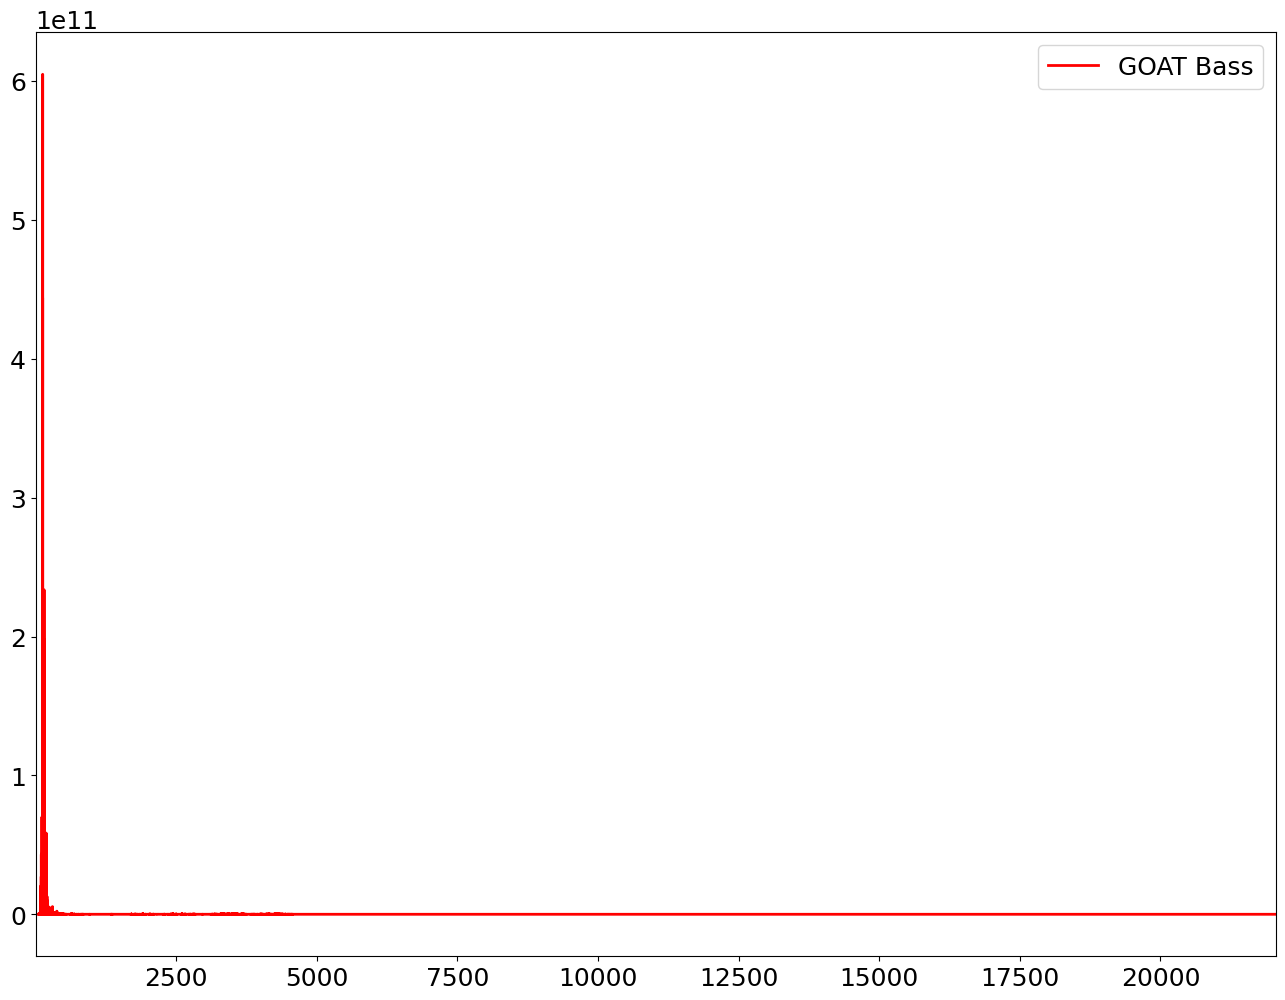

In [ ]:
### APPLY FFT TO OUR WAV ###

t = signal / sample_rate
n = len(signal) # Total samples
fhat = np.fft.fft(signal, n) # Compute FFT

PSD = fhat * np.conj(fhat) / n   # lambda * conj(lambda) = |lambda|^2 = a^2 + b^2
                                  # lambda = a + bi, conj(lambda) = a - bi
                                  # Vector that maps some value of magnitude/power to each frequency
                                  # This will be the new y-axis
freq = (sample_rate / n) * np.arange(n) # 1729315 samples => 1729315 frequency values
                                        # Our x-axis
L = np.arange(1, np.floor(n / 2), dtype='int')

plt.plot(freq[L], PSD[L], color='red', linewidth=2, label='GOAT Bass')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.show()

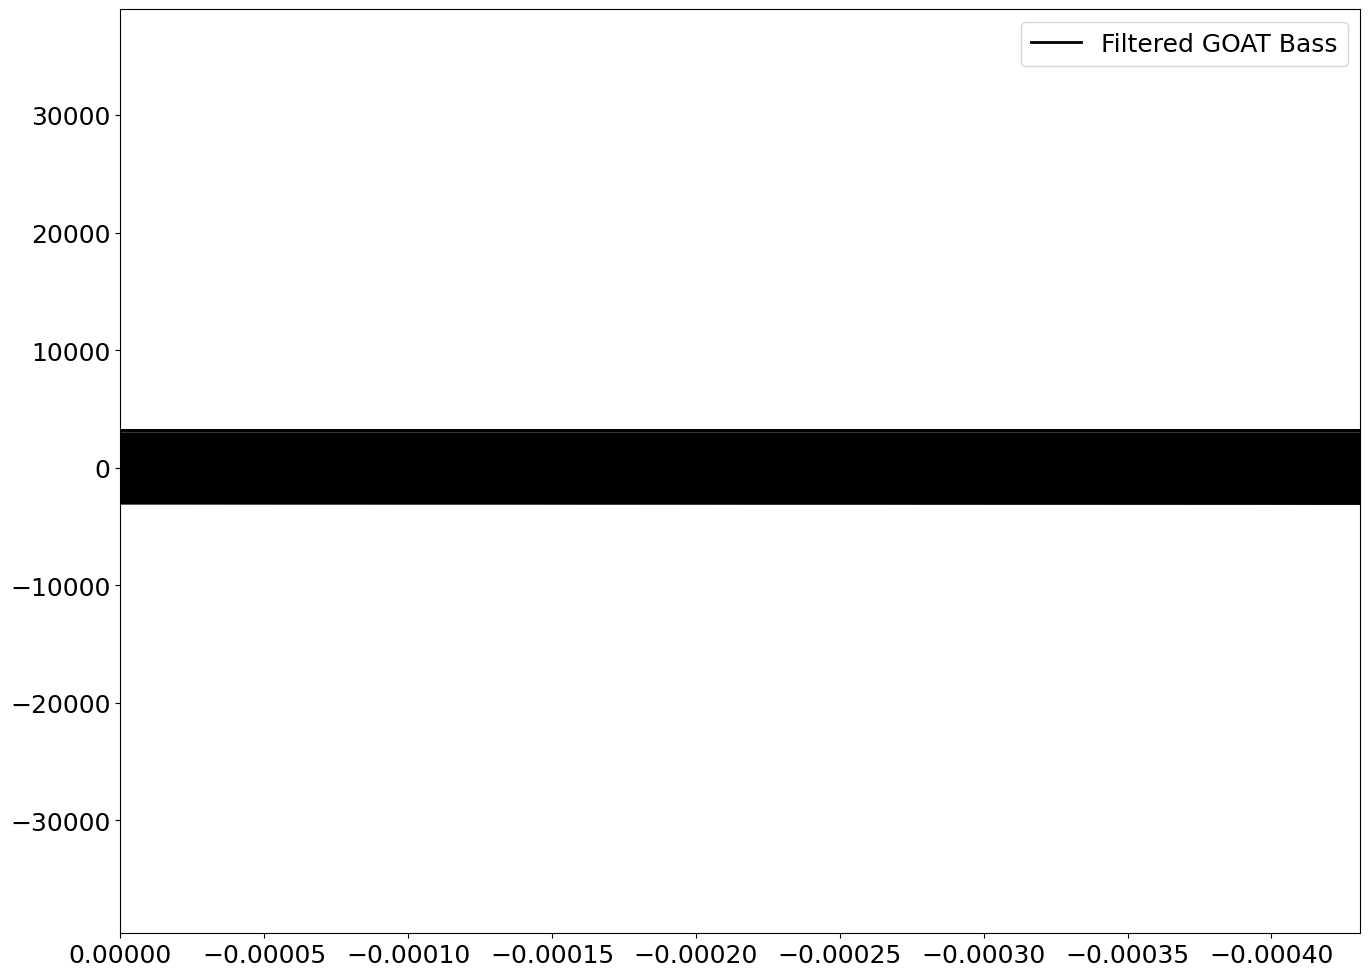

In [ ]:
### FILTER AND APPLY IFFT ###

indices = PSD > 0.00001e11
PSDclean = PSD * indices
fhat = indices * fhat

ffilt_goat = np.fft.ifft(fhat) # Apply inverse FFT on filtered signal

plt.plot(t, ffilt_goat, color='k', linewidth=2, label='Filtered GOAT Bass')
plt.xlim(t[0], t[-1])
plt.legend()

plt.show()

In [ ]:
### LET'S HEAR THE FILTERED SOUND ###
# %cd ./content

amplitude = 1
generateWav(ffilt_goat, amplitude, sample_rate, "ffilt_goat")

<ipython-input-79-ff059c0ccc82>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  write(f"{name}.wav", sample_rate, data.astype(np.int16))


It doesn't sound good. But it works!